In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla P100-PCIE-16GB


In [2]:
!nvidia-smi

Sat May 29 18:58:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    61W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
filename='/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_quad_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename='/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_quad_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit

In [4]:
x = np.load('/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_plimit_x.npy')
y = np.load('/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_plimit_y.npy')
W=np.load('/content/drive/MyDrive/gnn/data/2383dc_w.npy')
gpw=(W!=0).astype(int)
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float()
        self.labels=torch.from_numpy(np.transpose(labels)).float()
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X.t(),(1,-1))
        y = torch.reshape(y,(1,-1))
        return X, y
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 4}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(2383, 4, 6316) (2383, 6316)
3397.03 -434.91 7750.1 -2584.8
Training data size: (2383, 4, 5052)
Training label size: (2383, 5052)


In [5]:
W1 = W.copy()
W1 = np.asarray(W1)
# print(np.asarray([[2,3],[4,7]])/5)
W1 = W1 / 1
W2 = W1.copy()
print(type(W))
lam,v = np.linalg.eig(W1)
print(lam[0])
for i in range(5):
  W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
  # print(W1)
  lam,v = np.linalg.eig(W1)
  print(lam[0])#/10**(i+1))

<class 'numpy.ndarray'>
11.028229112322602
(1.3513537483764269+0j)
(1.434517098823738+0j)
(1.4929220146682691+0j)
(1.5347892586266945+0j)
(1.5650082712519962+0j)


In [6]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class graph_prune(nn.Module):
    def __init__(self,in_features,out_features,w,bias=True):
        super(graph_prune,self).__init__()
        # enlarge w
        W=np.zeros([w.shape[0]*in_features,w.shape[0]*out_features])
        for i in range(w.shape[0]):
          for j in range(w.shape[1]):
            W[i*in_features:(i+1)*in_features,j*out_features:(j+1)*out_features]+=1
        self.register_buffer('w',torch.from_numpy(W).float())
        self.mapping=nn.Parameter(torch.Tensor(W.shape[0],W.shape[1]))
        self.bias=nn.Parameter(torch.Tensor(1,W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping,self.w)
        h=torch.matmul(input,h)
        h=h+self.bias
        return h 

# graph prune NN
class GP(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus):
        super(GP, self).__init__()
        self.conv_v2v1=graph_prune(in_feats,hidden_size[0],W)
        self.conv_v2v2=graph_prune(hidden_size[0],hidden_size[1],W)
        self.conv_v2v3=graph_prune(hidden_size[1],hidden_size[2],W)
        self.conv_v2v4=graph_prune(hidden_size[2],hidden_size[3],W)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h = self.lin_output(h)
        return h
n_bus=x.shape[0]
w_params=[2,4,4,1]
net=GP(x_train.shape[1],w_params,gpw,n_bus) # Laplacian
net=net.to(device)

optimizer=torch.optim.Adam(net.parameters())
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

GP(
  (conv_v2v1): graph_prune()
  (conv_v2v2): graph_prune()
  (conv_v2v3): graph_prune()
  (conv_v2v4): graph_prune()
  (lin_output): Linear(in_features=2383, out_features=2383, bias=True)
)
number of params: 210140089


In [7]:
!nvidia-smi

Sat May 29 19:00:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    56W / 250W |   2541MiB / 16280MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    output=torch.where(x<left_thresh,0.,x)
    output=torch.where(output>right_thresh,right_thresh,output)
    return output
gen_pred_binary_cell=my_gen_pred_binary() # threshold function

loss_func=nn.MSELoss()
def f_feas_reg(train_batch,pred_label,binary_thres,S,f_max):
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  p_max=train_batch[:,0,0::x_train.shape[1]].transpose(0,1) - train_batch[:,0,1::x_train.shape[1]].transpose(0,1)
  quadratic_b=train_batch[:,0,2::x_train.shape[1]].transpose(0,1)
  quadratic_a=train_batch[:,0,3::x_train.shape[1]].transpose(0,1)
  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2
  gen_pred_binary = gen_pred_binary_cell(quadratic_center,p_max)
  p_inj=gen_pred_binary
  bus_inj = p_inj + train_batch[:,0,1::x_train.shape[1]].transpose(0,1)
  f = torch.matmul(S,bus_inj)
  f=torch.abs(f)
  f_penalty=torch.where(f>f_max,f-f_max,0.)
  return f_penalty

def my_loss_func(pred,label,W1,train_batch,S,f_max):
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  lmda4=torch.from_numpy(np.array([0.1])).to(device) # f-feasibility

  binary_thres = 0.97 # P_g threshold for 0
  binary_thres = torch.tensor(binary_thres).to(device)

  mse=loss_func(pred,label)
  linf=(pred-label).norm(p=float('inf'))
  f_penalty = f_feas_reg(train_batch,pred,binary_thres,S,f_max)
  return lmda1*mse+lmda2*linf#+lmda4*torch.sum(f_penalty)

In [9]:
t0=time.time()
max_epochs=200
eval_epoch=5

# earlystopping
tolerance=5
min_delta=1e-4
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    local_batch,local_label=local_batch.to(device),local_label.to(device)
    optimizer.zero_grad() # clear the past gradient
    logits=net(local_batch)
    loss=my_loss_func(logits,local_label,W_tensor,local_batch,S,f_max)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=loss=my_loss_func(logits,eval_label,W_tensor,eval_batch,S,f_max)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
t1=time.time()
print("Training time:%.4fs"%(t1-t0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch 0 | Training loss: 8458.1176
Epoch 1 | Training loss: 838.4523
Epoch 2 | Training loss: 144.1399
Epoch 3 | Training loss: 83.0648
Epoch 4 | Training loss: 73.2928
Epoch 4 | Eval loss: 69.7637
Epoch 5 | Training loss: 71.0695
Epoch 6 | Training loss: 70.0405
Epoch 7 | Training loss: 72.0191
Epoch 8 | Training loss: 68.0346
Epoch 9 | Training loss: 73.6576
Epoch 9 | Eval loss: 91.4292
Epoch 10 | Training loss: 72.0558
Epoch 11 | Training loss: 65.0431
Epoch 12 | Training loss: 69.1283
Epoch 13 | Training loss: 68.8030
Epoch 14 | Training loss: 62.1932
Epoch 14 | Eval loss: 59.4827
Epoch 15 | Training loss: 77.9268
Epoch 16 | Training loss: 93.5266
Epoch 17 | Training loss: 65.9367
Epoch 18 | Training loss: 63.7967
Epoch 19 | Training loss: 60.9503
Epoch 19 | Eval loss: 59.6962
Epoch 20 | Training loss: 69.2339
Epoch 21 | Training loss: 68.5616
Epoch 22 | Training loss: 65.8887
Epoch 23 | Training loss: 64.0539
Epoch 24 | Training loss: 58.4459
Epoch 24 | Eval loss: 54.3314
Epoch 25

In [10]:
print(len(loss_val))
print(loss_val[0][0])
# print(val_plt)
print(logits.shape,eval_label.shape)

7
4
torch.Size([240, 1, 2383]) torch.Size([240, 1, 2383])


7


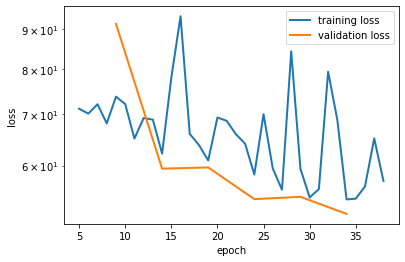

In [11]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

In [12]:
n_test = x_test.shape[-1]

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = torch.transpose(x_test_feed,1,2).reshape(n_test,1,-1)
x_test_feed = x_test_feed.transpose(1,1)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
net.eval()
y_pred = net(x_test_feed)
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape,y_pred1.shape)

Validation dataset size: torch.Size([1264, 1, 9532])
Number of validation set:  1264
(2383, 1264) (2383, 1264)


In [13]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))
print(err_L2.shape,err_Linf.shape)

(1264,) (1264,)


L2 mean: 0.05890987898209373 L_inf mean: 0.1743949880909412


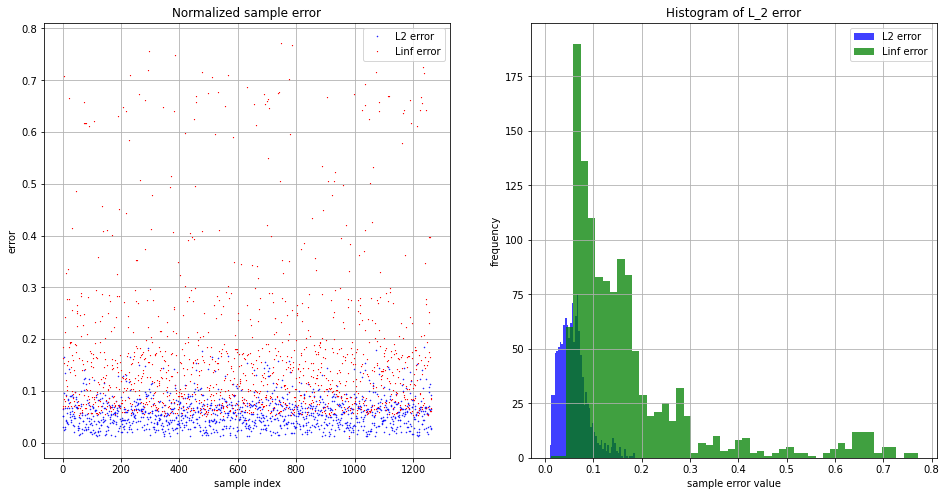

In [14]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

1264 L2 mean: 0.05890987898209373 1264 L_inf mean: 0.1743949880909412


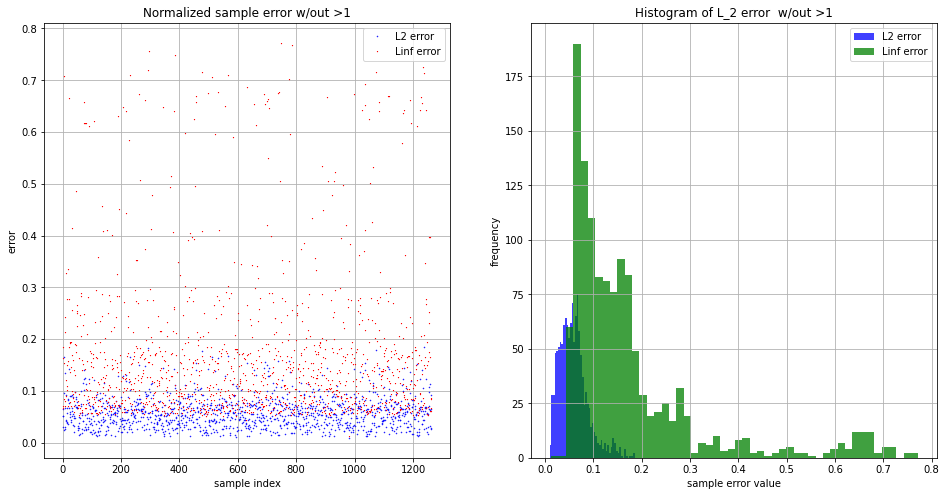

In [15]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [16]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(2383, 4, 5052)


In [17]:
# print(y_test[:,1], y_pred1[:,1])
index = 1
y_test_copy = y_pred1[:,index].copy()
print(y_test_copy.shape)
for i in range(118):
  if y_test_copy[i] < 0.1:
    y_test_copy[i] = y_test[i,index] + 50

print(np.linalg.norm(y_test_copy - y_test[:,index]) / np.linalg.norm(y_test[:,index]))

(2383,)
0.05193256937446553


# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [18]:
gen_limit0 = x[:,2,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(2383, 6316)
<class 'numpy.ndarray'> 2383 [   0    1    2 ... 2380 2381 2382]


In [19]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
print(load_data.shape)
n_sample = np.size(load_data,2)

n_val=x.shape[-1]

x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
x_val_feed = x_val_feed.to(device)
x_val_feed=x_val_feed.transpose(1,2).reshape(n_val,1,-1)

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)
y_pred = net(x_val_feed) # predict the corredponding LMP

y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

(2383, 4, 6316)
Dataset size: torch.Size([6316, 1, 9532])
Number of validation points::  6316


* Save results

In [20]:
import pickle
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [21]:
gen_cost0 = x[:,2,:].copy()
lmp_data = y.copy()

quadratic_a = x[:,3,:].copy()

profit_pred = y_pred1 - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)


44.19273376464844
0.0033774
31.705989376473
11.796693516580735
(15051028,)


In [ ]:
gen_pred_binary = np.zeros((len(gen_idx),n_sample))
gen_true_binary = np.zeros((len(gen_idx),n_sample))
print(gen_pred_binary.shape)

binary_thres = 0.97
binary_thres_true = 1e-5

for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres:
      gen_pred_binary[j,i] = 1
    elif profit_pred[gen_idx[j],i] < 1-binary_thres:
      gen_pred_binary[j,i] = 0
    else:
      gen_pred_binary[j,i] = 0.5
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres_true:
      gen_true_binary[j,i] = 1
    elif profit_true[gen_idx[j],i] < 1e-5:
      gen_true_binary[j,i] = 0
    else:
      gen_true_binary[j,i] = 0.5


(2383, 6316)


In [ ]:
gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
print('max binary error:',np.max(gen_binary_err))
# count the wrong entries
gen_binary_err_ct = np.sum(gen_binary_err)
gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
print('Binary accuracy:',1-gen_binary_err_ratio)

In [ ]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

In [ ]:
binary_thres_true = 1e-5
binary_thres = x[:,0,:].copy() # upper
binary_thres_lo = x[:,1,:].copy() # lower
gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))

for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

print(np.sum(p_inj_true),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
f_max_numpy = f_max.cpu().detach().numpy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

f_tot_sample = n_line * n_sample

f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

3954736.4014139166 3954736.4014139166
3473186.037343486 158180831.57430428 3473186.037343486
4126 29
0.00022557374238538273 1.5854674089132572e-06
